Set up custom dataset provider

In [3]:
import torch
from scipy.io import loadmat
from torch.utils.data import Dataset


class SVHN_dataset(Dataset):

    def __init__(self, data):
        self.data = data
        images = torch.tensor(data['X']).permute([3, 2, 0, 1])
        self.labels = torch.tensor(data['y'], dtype=torch.long)
        self.size = self.labels.shape[0]

        # Replace label 10 with label 0
        for label in self.labels:
            if label.item() == 10:
                label[0] = 0

        # Convert to float and normalize to [0, 1] range
        self.normalized_images = [image.type(torch.FloatTensor) / 255 for image in images]
        for image in self.normalized_images:
            image.type(torch.FloatTensor)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.normalized_images[idx], self.labels[idx].item()



Load the data

In [4]:
from scipy.io import loadmat

!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

training_data = loadmat("train_32x32.mat")
training_dataset = SVHN_dataset(training_data)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=512, shuffle=True)

test_data = loadmat("test_32x32.mat")
test_dataset = SVHN_dataset(test_data)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


--2021-08-07 15:49:06--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.2’

train_32x32.mat.2   100%[===================>] 173.61M  85.9MB/s    in 2.0s    

2021-08-07 15:49:08 (85.9 MB/s) - ‘train_32x32.mat.2’ saved [182040794/182040794]

--2021-08-07 15:49:08--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.2’

test_32x32.mat.2    100%[===================>]  61.30M  81.9MB/s    in 0.7s    

2021-08-07 15:49:09 (81.9 MB/s) - ‘test_32x32.mat.2’ saved [642

Define function for calculating accuracy

In [5]:
def get_accuracy(model, dataloader):
    model.eval()

    correctly_classified = 0
    number_of_images = len(dataloader)

    for image, label in dataloader:
        output = model(image.to("cuda"))
        prediction = torch.argmax(output)

        if prediction.item() == label.item():
            correctly_classified += 1

    model.train()

    return correctly_classified / number_of_images


Define model

In [6]:
import torch.nn as nn


def get_model():
    return nn.Sequential(
        nn.Conv2d(stride=1, padding=2, kernel_size=5, in_channels=3, out_channels=6),
        nn.BatchNorm2d(num_features=6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(kernel_size=3, stride=1, padding=1, out_channels=12, in_channels=6),
        nn.BatchNorm2d(num_features=12),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(kernel_size=3, out_channels=24, stride=1, padding=1, in_channels=12),
        nn.BatchNorm2d(num_features=24),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(in_features=24 * 4 * 4, out_features=10)
    )


Train the model

In [7]:
import torch

from torch import optim

model = get_model().to('cuda')

learning_rate = 1e-3

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100


for epoch in range(n_epochs):
    for images, labels in training_dataloader:
        batch_size = images.shape[0]
        images, labels = images.to('cuda'), labels.to('cuda')

        outputs = model(images)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

    if epoch % 10 == 0:
        accuracy = get_accuracy(model, test_dataloader)
        print(f"Accuracy:{accuracy}")

        if accuracy > 0.9:
            break


Training on device cuda.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Loss: 0.901850
Accuracy:0.7637907191149355
Epoch: 1, Loss: 0.921785
Epoch: 2, Loss: 0.794932
Epoch: 3, Loss: 0.487384
Epoch: 4, Loss: 0.384394
Epoch: 5, Loss: 0.506934
Epoch: 6, Loss: 0.247229
Epoch: 7, Loss: 0.403344
Epoch: 8, Loss: 0.346464
Epoch: 9, Loss: 0.657572
Epoch: 10, Loss: 0.830681
Accuracy:0.8552166564228642
Epoch: 11, Loss: 0.797756
Epoch: 12, Loss: 0.410128
Epoch: 13, Loss: 0.151268
Epoch: 14, Loss: 0.251959
Epoch: 15, Loss: 0.181019
Epoch: 16, Loss: 0.359995
Epoch: 17, Loss: 0.236962
Epoch: 18, Loss: 0.241343
Epoch: 19, Loss: 0.121585
Epoch: 20, Loss: 0.202488
Accuracy:0.8773432698217578
Epoch: 21, Loss: 0.231255
Epoch: 22, Loss: 0.318156
Epoch: 23, Loss: 0.444947
Epoch: 24, Loss: 0.292300
Epoch: 25, Loss: 0.447368
Epoch: 26, Loss: 0.305701
Epoch: 27, Loss: 0.311373
Epoch: 28, Loss: 0.281819
Epoch: 29, Loss: 0.418111
Epoch: 30, Loss: 0.359548
Accuracy:0.8753073140749846
Epoch: 31, Loss: 0.151140
Epoch: 32, Loss: 0.213013
Epoch: 33, Loss: 0.279368
Epoch: 34, Los

Compute the final accuracy

In [8]:
accuracy = get_accuracy(model, test_dataloader)
print(f"Accuracy:{accuracy}")

Accuracy:0.8854870928088506


Show some correctly classified images

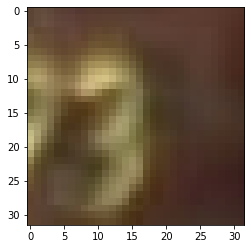

Digit label: 3


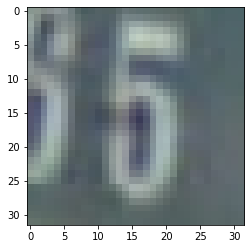

Digit label: 5


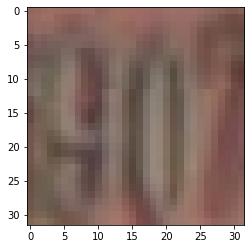

Digit label: 0


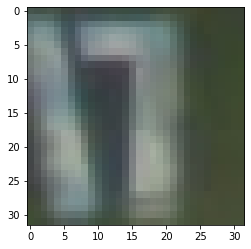

Digit label: 7


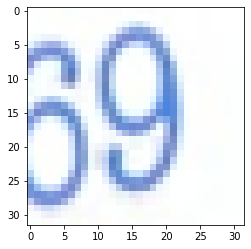

Digit label: 9


Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=384, out_features=10, bias=True)
)

In [14]:
import random
import matplotlib.pyplot as plt


model.eval()

correctly_classified = 0
number_of_images = len(test_dataset)
random.seed(1)

while correctly_classified < 5:
  image_number = random.randrange(number_of_images)
  image, label = test_dataset[image_number]

  output = model(torch.unsqueeze(image.to("cuda"), 0))
  prediction = torch.argmax(output)

  if prediction.item() == label:
    correctly_classified += 1

    plt.imshow(test_dataset.data['X'][:, :, :, image_number])
    plt.show()
    print(f"Digit label: {label}")

model.train()